# UCI HAR - classification
- https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

#### 데이터 종류
- 561개 특성으로 전처리된 메인 데이터셋(X_train, X_test)
- Inertial Signals 데이터셋: 원시 센서 값(raw signal)

#### Inertial Signals 데이터 구조
- 각 파일은 행 = 샘플(segment), 열 = 시계열 프레임을 의미
- 각 샘플은 2.56초 길이 (샘플링 주파수 50Hz, 128 타임스텝 → 128 / 50 = 2.56초)
- 이미 샘플링이 되어 있으므로(7352개의 샘플) split_sequence() 사용하지 않아도 됨
- 한 행이 (128,) 길이의 시계열 벡터
- 세 축(X, Y, Z)와 센서 종류(acc, gyro)로 분리되어 있음

#### 센서 및 값의 의미
- Total acceleration (total_acc): 스마트폰 가속도계로 측정한 총 가속도 (중력 + 신체 움직임 포함)
- Body acceleration (body_acc): 총 가속도에서 중력 성분을 제거한 값 (실제 동작 가속도)
- Gyroscope (body_gyro): 각속도(회전 속도), 단위는 rad/sec, 스마트폰의 자이로스코프 센서 값

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [4]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_data/UCI HAR Dataset/"

# Load "X"
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []  # 한 센서축 데이터 전체 저장

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("첫 번째 샘플 데이터:\n", X_train[0])


X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
첫 번째 샘플 데이터:
 [[ 1.808515e-04  1.076681e-02  5.556068e-02 ...  1.012817e+00
  -1.232167e-01  1.029341e-01]
 [ 1.013856e-02  6.579480e-03  5.512483e-02 ...  1.022833e+00
  -1.268756e-01  1.056872e-01]
 [ 9.275574e-03  8.928878e-03  4.840473e-02 ...  1.022028e+00
  -1.240037e-01  1.021025e-01]
 ...
 [-1.147484e-03  1.714439e-04  2.647864e-03 ...  1.018445e+00
  -1.240696e-01  1.003852e-01]
 [-2.222655e-04  1.574181e-03  2.381057e-03 ...  1.019372e+00
  -1.227451e-01  9.987355e-02]
 [ 1.575500e-03  3.070189e-03 -2.269757e-03 ...  1.021171e+00
  -1.213260e-01  9.498741e-02]]


In [9]:
# Load "y"

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    # 라벨을 0부터 시작하도록 -1 (원래 라벨이 1부터 시)
    return np.array(labels, dtype=np.int32) - 1


y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train[:5])

y_train shape: (7352,)
y_test shape: (2947,)
[4 4 4 4 4]


In [11]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = 6

model = Sequential([
            Input(shape=input_shape), # time_steps, n_features
            SimpleRNN(128, return_sequences=True, dropout=0.2),
            SimpleRNN(64, dropout=0.2),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128, 128)       │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,294 (126.15 KB)

 Trainable params: 32,294 (126.15 KB)

 Non-trainable params: 0 (0.00 B)

None


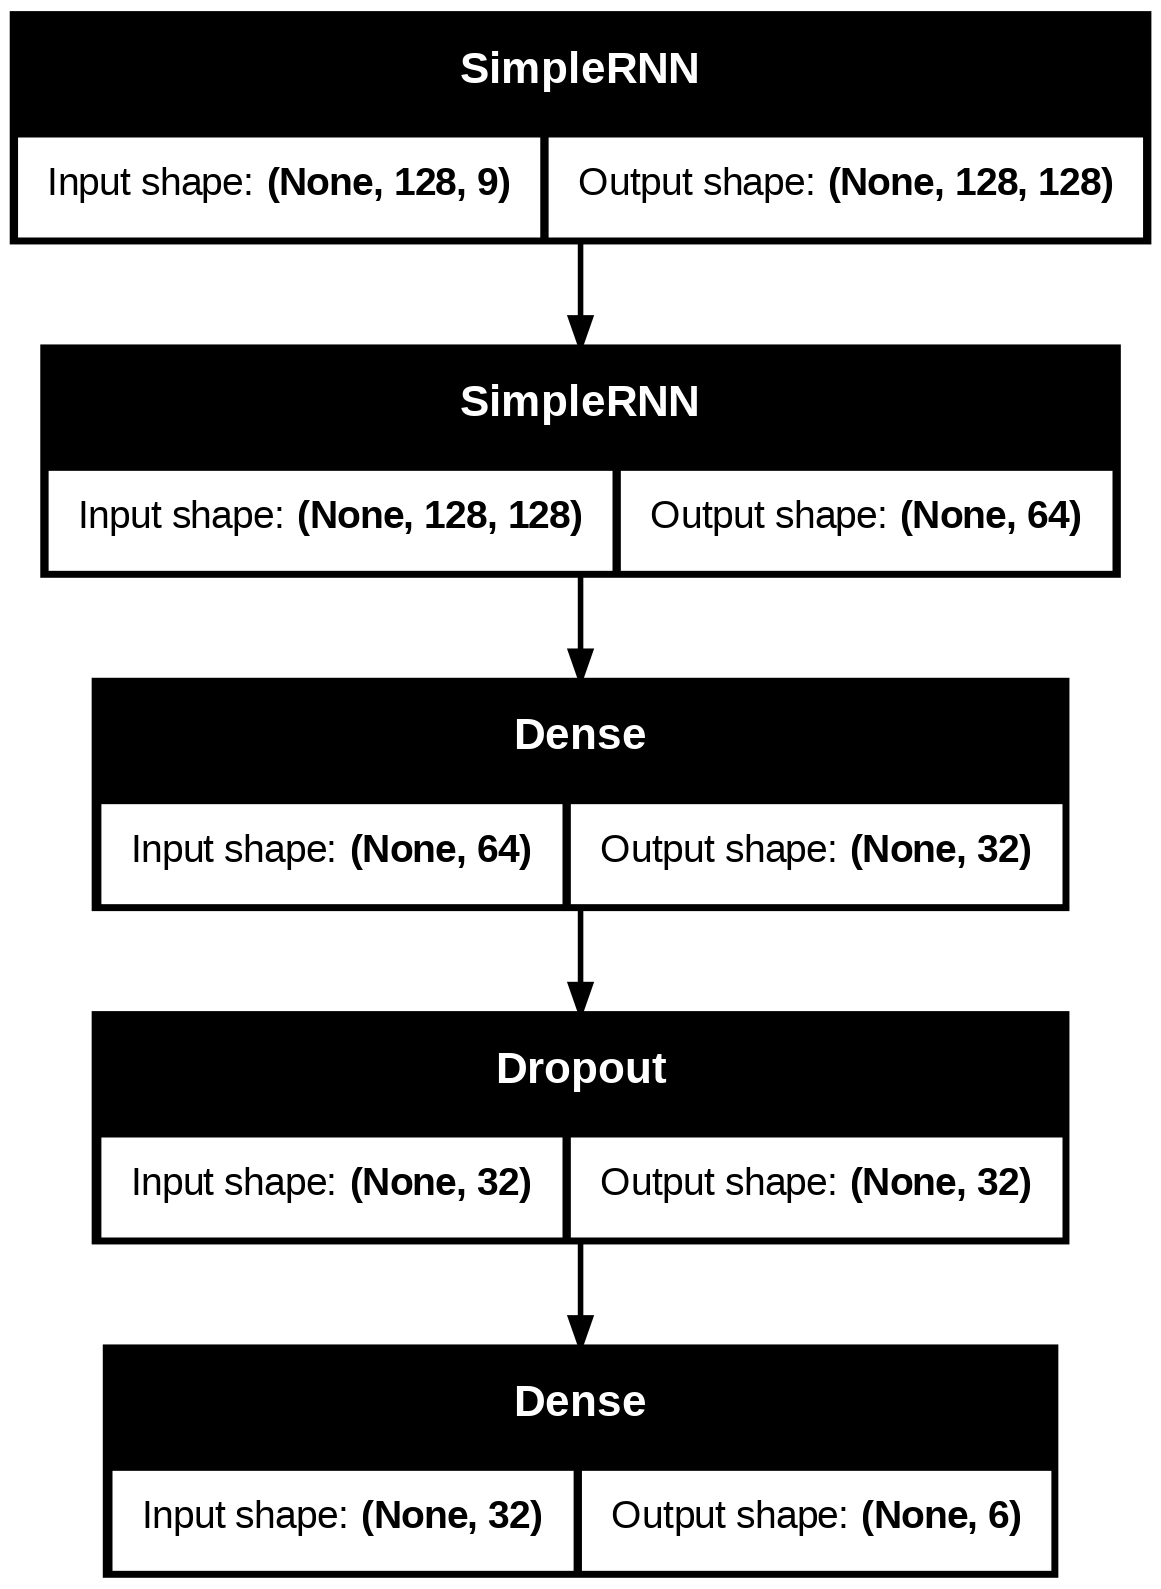

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_RNN_best.h5",
                save_best_only=True,
                monitor="sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [14]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.5910 - sparse_categorical_accuracy: 0.3146
Epoch 1: sparse_categorical_accuracy improved from -inf to 0.34875, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 1.5906 - sparse_categorical_accuracy: 0.3147
Epoch 2/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.4212 - sparse_categorical_accuracy: 0.4034
Epoch 2: sparse_categorical_accuracy improved from 0.34875 to 0.42954, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 1.4203 - sparse_categorical_accuracy: 0.4037
Epoch 3/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1641 - sparse_categorical_accuracy: 0.5067
Epoch 3: sparse_categorical_accuracy improved from 0.42954 to 0.51564, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.1637 - sparse_categorical_accuracy: 0.5068
Epoch 4/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0708 - sparse_categorical_accuracy: 0.5380
Epoch 4: sparse_categorical_accuracy improved from 0.51564 to 0.54924, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.0705 - sparse_categorical_accuracy: 0.5381
Epoch 5/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9226 - sparse_categorical_accuracy: 0.5969
Epoch 5: sparse_categorical_accuracy improved from 0.54924 to 0.59684, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.9224 - sparse_categorical_accuracy: 0.5969
Epoch 6/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8953 - sparse_categorical_accuracy: 0.6029
Epoch 6: sparse_categorical_accuracy did not improve from 0.59684
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.8955 - sparse_categorical_accuracy: 0.6028
Epoch 7/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8650 - sparse_categorical_accuracy: 0.6039
Epoch 7: sparse_categorical_accuracy improved from 0.59684 to 0.60909, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.8650 - sparse_categorical_accuracy: 0.6039
Epoch 8/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8164 - sparse_categorical_accuracy: 0.6213
Epoch 8: sparse_categorical_accuracy improved from 0.60909 to 0.61983, saving model to UCI_HAR_RNN_best.h5


230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8165 - sparse_categorical_accuracy: 0.6213
Epoch 9/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9096 - sparse_categorical_accuracy: 0.5916
Epoch 9: sparse_categorical_accuracy did not improve from 0.61983
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.9094 - sparse_categorical_accuracy: 0.5918
Epoch 10/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1319 - sparse_categorical_accuracy: 0.5394
Epoch 10: sparse_categorical_accuracy did not improve from 0.61983
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.1331 - sparse_categorical_accuracy: 0.5389
Epoch 11/100
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6746 - sparse_categorical_accuracy: 0.3000
Epoch 11: sparse_categorical_accuracy did not improve from 0.61983
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.6735 - sparse_categorical_accuracy: 0.3005
Epoch 12/100
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.3725 - sparse_categorical_accura

In [16]:
# 모델 평가
model = tf.keras.models.load_model("UCI_HAR_RNN_best.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

Training accuracy: 74.52%
Training loss: 0.6158


model.predict
- 각 시퀀스 샘플마다, 모든 클래스에 대한 예측 확률 벡터
- y_pred_proba.shape -> (샘플 수, 클래스 수)

np.argmax
- 최대 값의 인덱스를 선택 = 라벨

In [20]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.4557    0.5282    0.4893       496
           1     0.5850    0.6943    0.6350       471
           2     0.6121    0.4810    0.5387       420
           3     0.8575    0.6741    0.7548       491
           4     0.7575    0.8515    0.8018       532
           5     0.9900    0.9199    0.9537       537

    accuracy                         0.7021      2947
   macro avg     0.7096    0.6915    0.6955      2947
weighted avg     0.7174    0.7021    0.7049      2947



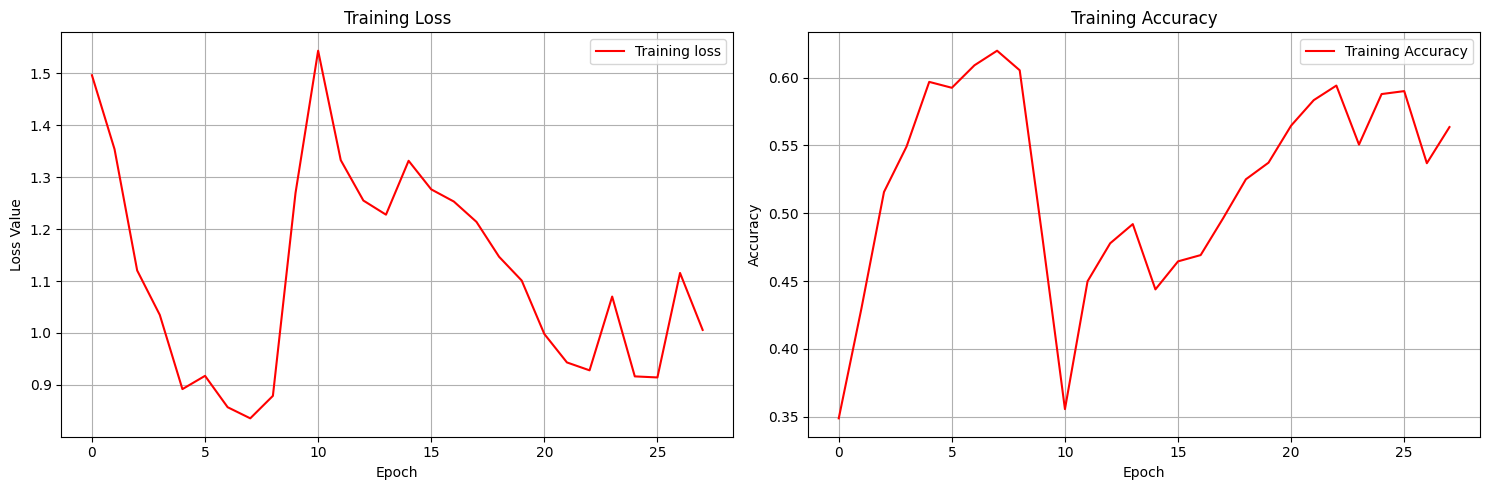

In [21]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

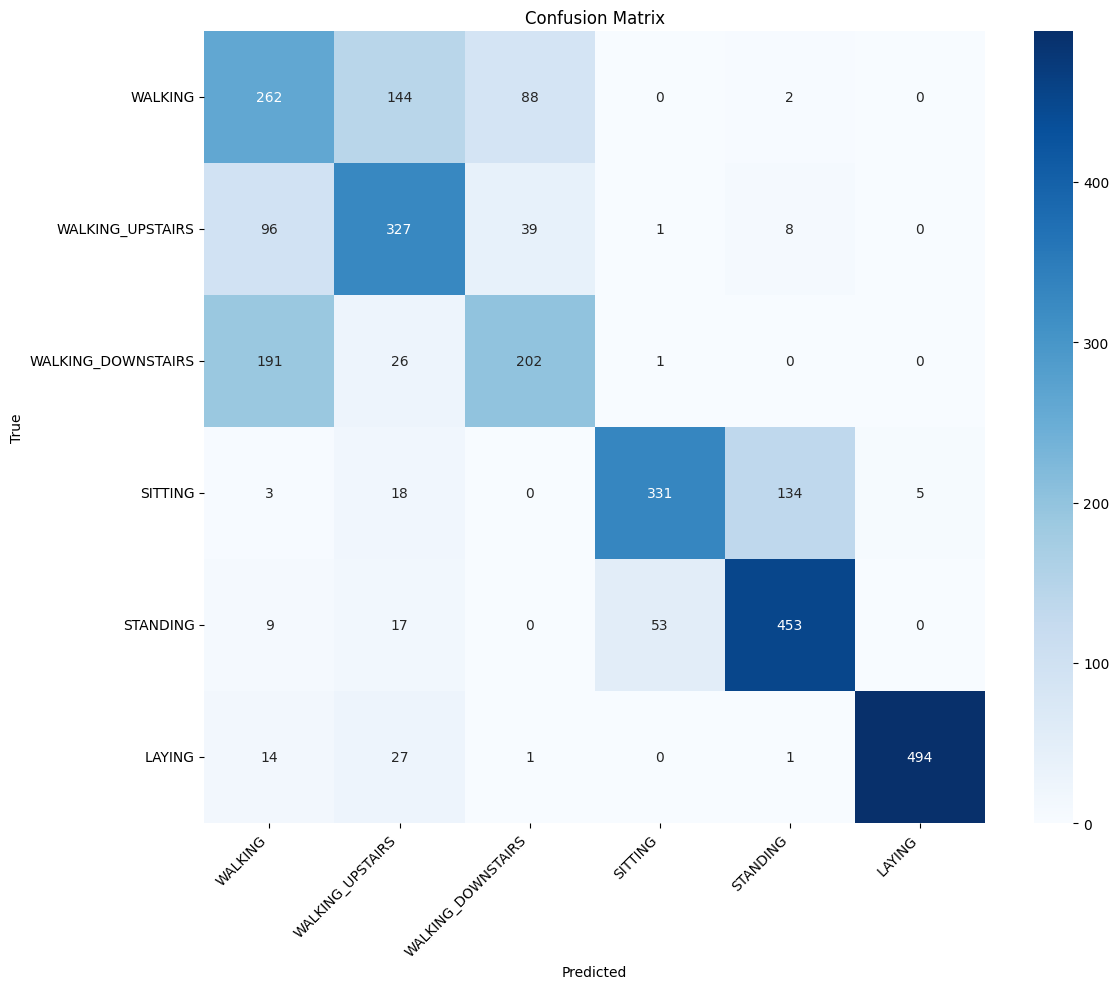

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()